In [ ]:
# Data commands:
# `python comet_download.py --project=feature-recycling-initial-step-size-adaptation-v1 --n_threads=8`

In [2]:
import itertools
import re
import sys

sys.path.append('../')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from tqdm import tqdm

from IPython.display import display

from plotting_utils import *

sns.set_theme('notebook', 'white')
%matplotlib inline

In [13]:
all_sweeps_config_df['feature_recycling|initial_step_size_method']

0      constant
1          mean
2      constant
3      constant
4          mean
         ...   
988      median
989      median
990      median
991      median
992      median
Name: feature_recycling|initial_step_size_method, Length: 908, dtype: object

In [ ]:
save_path = 'figures/'
config_data_path = 'data/feature-recycling-initial-step-size-adaptation-v1_params.csv'
run_data_path = f'data/feature-recycling-initial-step-size-adaptation-v1_metrics.csv'

all_sweeps_config_df = pd.read_csv(config_data_path, index_col=0)
all_sweeps_run_df = pd.read_csv(run_data_path, index_col=0)

# Remove duplicate config rows, ignoring run_id column
all_sweeps_config_df = all_sweeps_config_df.drop_duplicates(
    subset = [col for col in all_sweeps_config_df.columns if col != 'run_id'],
    keep = 'last',
)
valid_run_ids = set(all_sweeps_config_df['run_id'].unique())
all_sweeps_run_df = all_sweeps_run_df[all_sweeps_run_df['run_id'].isin(valid_run_ids)]
all_sweeps_run_df = all_sweeps_run_df.dropna(subset=['step'])

all_sweeps_config_df.loc[
    (all_sweeps_config_df['sweep_name'] == 'ns_meta_step_size') &
    (all_sweeps_config_df['feature_recycling|initial_step_size_method'] != 'constant'),
    'sweep_name'
] = 'ns_full_sweep'

sweep_names = list(all_sweeps_config_df['sweep_name'].unique())

# Split up dfs by sweep name
run_dfs = {}
config_dfs = {}
for sweep_name in sweep_names:
    config_dfs[sweep_name] = all_sweeps_config_df[all_sweeps_config_df['sweep_name'] == sweep_name].reset_index(drop=True)
    # Drop experiments that did not complete
    max_step = config_dfs[sweep_name]['curr_step'].max()
    config_dfs[sweep_name] = config_dfs[sweep_name][config_dfs[sweep_name]['curr_step'] == max_step]
    
    run_ids = set(config_dfs[sweep_name]['run_id'].unique())
    run_dfs[sweep_name] = all_sweeps_run_df[all_sweeps_run_df['run_id'].isin(run_ids)].reset_index(drop=True)

# # Add in an extra baseline df
# config_dfs['baseline'] = config_dfs['distractor_chance'][config_dfs['distractor_chance']['task|distractor_chance'] == 0]
# vanilla_run_ids = set(config_dfs['baseline']['run_id'].unique())
# run_dfs['baseline'] = run_dfs['distractor_chance'][run_dfs['distractor_chance']['run_id'].isin(vanilla_run_ids)]

In [17]:
{k: len(v) for k, v in config_dfs.items()}

{'adaptation_type_and_decay': 144,
 'ns_full_sweep': 239,
 'ns_meta_step_size': 45,
 'ns_a0_adaptation': 480}

## Plotting functions

In [18]:
def plot_ablation_figure(
        run_df, config_df, x_col, title, x_label, y_label,
        hue_col='model|hidden_dim', metric_type='cumulative', # {'cumulative', 'final'}
        show_ci=False, plot_baseline=False,
    ):
    if metric_type.lower() == 'cumulative':
        final_step_df = run_df.sort_values('step').groupby('run_id').last().reset_index()
        final_step_df = final_step_df.merge(config_df, on='run_id', how='left')
        y_col = 'cumulative_loss'
        y_label = f'Cumulative {y_label}'

    elif metric_type.lower() == 'final':
        # Get the last 5% of steps for each run
        max_steps_per_run = run_df.groupby('run_id')['step'].max()
        threshold_steps = max_steps_per_run * 0.95

        # Filter for last 5% of steps and calculate mean loss
        final_loss_df = run_df.merge(
            threshold_steps.rename('threshold_step'),
            left_on='run_id',
            right_index=True
        )
        final_loss_df = final_loss_df[final_loss_df['step'] >= final_loss_df['threshold_step']]
        final_loss_df = final_loss_df.groupby('run_id')[['loss', 'mean_prediction_loss']].mean().reset_index()
        
        # Merge with config data
        final_loss_df = final_loss_df.merge(config_df, on='run_id', how='left')
        final_step_df = final_loss_df

        y_col = 'loss'
        y_label = f'{y_label} (Final 5%)'
        
    else:
        raise ValueError(f"Invalid metric type: {metric_type}!")

    # Create a mapping of actual values to evenly spaced positions
    x_values = sorted(final_step_df[x_col].unique())
    x_positions = np.arange(len(x_values))
    x_map = dict(zip(x_values, x_positions))

    # Create temporary column with evenly spaced x positions
    final_step_df['x_position'] = final_step_df[x_col].map(x_map)

    # Create plot with evenly spaced x positions
    sns.lineplot(
        data = final_step_df,
        x = 'x_position',
        y = y_col, 
        hue = hue_col,
        marker = 'o',
        palette = 'deep',
        errorbar = ('ci', 95) if show_ci else None,
    )

    if plot_baseline:
        sns.lineplot(
            data = final_step_df,
            x = 'x_position',
            y = 'mean_prediction_loss',
            color = 'black',
            label = 'Baseline',
        )

    # Customize plot
    plt.grid(True, alpha=0.4)  # Add light grid
    plt.xlim(-0.1, len(x_values) - 0.9)  # Add small padding on both sides
    plt.xticks(x_positions, x_values)  # Use original values as labels
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.legend(title='# Hidden Units')


def plot_ablation_comparison(
        run_df, config_df, x_col, title, x_label, y_label,
        hue_col='model|hidden_dim', figsize=(12, 5), show_ci=False,
        plot_baseline=True,
    ):
    """Creates side-by-side plots comparing cumulative and final metrics.
    
    Args:
        run_df: DataFrame containing run data
        config_df: DataFrame containing config data 
        x_col: Column to plot on x-axis
        title: Title for the overall figure
        x_label: Label for x-axis
        y_label: Label for y-axis
        hue_col: Column to use for line colors
        figsize: Figure size as (width, height) tuple
        show_ci: Whether to show 95% confidence intervals
        plot_baseline: Whether to plot the baseline model
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)
    
    plt.sca(ax1)
    plot_ablation_figure(
        run_df = run_df,
        config_df = config_df,
        x_col = x_col,
        title = title,
        x_label = x_label,
        y_label = y_label,
        hue_col = hue_col,
        metric_type = 'cumulative',
        show_ci = show_ci,
        plot_baseline = False,
    )
    
    plt.sca(ax2)
    plot_ablation_figure(
        run_df = run_df,
        config_df = config_df,
        x_col = x_col,
        title = title,
        x_label = x_label,
        y_label = y_label,
        hue_col = hue_col,
        metric_type = 'final',
        show_ci = show_ci,
        plot_baseline = plot_baseline,
    )
    
    plt.tight_layout()

In [19]:
def plot_learning_curves(
        run_df,
        config_df,
        subplot_col = None,
        subplot_values = None,
        n_bins = 200,
        figsize = (12, 10),
        max_cols = 2,
        subplot_col_label = None,
        same_y_axis = True,
        y_col = 'loss',
        y_label = None,
        hue_col = 'model.hidden_dim',
        hue_label = '# Learning Hidden Units',
    ):
    """Creates subplots of learning curves for different values of a variable.
    
    Args:
        run_df: DataFrame containing run data
        config_df: DataFrame containing config data
        subplot_col: Column name to split subplots by. If None, creates single plot.
        subplot_values: List of values to plot. If None, uses all unique values
        n_bins: Number of bins for the learning curves
        figsize: Figure size as (width, height) tuple
        max_cols: Maximum number of columns in subplot grid
        subplot_col_label: Label for the subplot column
        same_y_axis: Whether all subplots should share the same y-axis scale
        y_col: Column to plot on y-axis (default: 'loss')
        y_label: Label for y-axis (default: same as y_col)
        hue_col: Column to use for line colors (default: 'model.hidden_dim')
        hue_label: Label for the hue legend (default: '# Learning Hidden Units')
    """
    # Get full dataset
    plot_df = run_df.merge(config_df, on='run_id', how='left')
    
    # Get subplot values if not provided
    if subplot_col is not None and subplot_values is None:
        subplot_values = sorted(plot_df[subplot_col].unique())
    elif subplot_col is None:
        subplot_values = [None]
    
    # Calculate number of rows/cols for subplots
    n_plots = len(subplot_values)
    n_cols = min(max_cols, n_plots)
    n_rows = (n_plots + n_cols - 1) // n_cols
    
    # Create figure
    fig, axes = plt.subplots(n_rows, n_cols, figsize=figsize)
    if n_rows == 1 and n_cols == 1:
        axes = np.array([axes])
    axes = axes.flatten()
    
    # Calculate mid 98% percentile for consistent y-axis if requested
    if same_y_axis:
        filtered_df = plot_df[
            (plot_df[y_col] >= np.percentile(plot_df[y_col], 1)) &
            (plot_df[y_col] <= np.percentile(plot_df[y_col], 99))
        ]
        y_range = filtered_df[y_col].max() - filtered_df[y_col].min()
        y_pad = y_range * 0.1
        y_min = filtered_df[y_col].min() - y_pad
        y_max = filtered_df[y_col].max() + y_pad

    # Get max step value for x-axis limit
    max_step = plot_df['step'].max()

    for i, val in enumerate(subplot_values):
        # Filter for current value if subplot_col exists
        curr_df = plot_df.copy()
        if subplot_col is not None:
            curr_df = plot_df[plot_df[subplot_col] == val].copy()
        
        # Bin data
        curr_df = bin_df(curr_df, n_bins=n_bins)
        curr_df = curr_df[curr_df[hue_col].notna()]  # Remove NaN values
        if hue_col == 'model.hidden_dim':
            curr_df[hue_col] = curr_df[hue_col].astype(int)
        
        # Create subplot
        sns.lineplot(
            data = curr_df,
            x = 'step',
            y = y_col,
            hue = hue_col, 
            palette = 'deep',
            errorbar = None,
            ax = axes[i]
        )
        
        # Customize subplot
        axes[i].grid(True, alpha=0.4)
        axes[i].set_xlim(0, max_step)
        if same_y_axis:
            axes[i].set_ylim(y_min, y_max)
        else:
            # Calculate y limits for this subplot
            filtered_curr_df = curr_df[
                (curr_df[y_col] >= np.percentile(curr_df[y_col], 1)) &
                (curr_df[y_col] <= np.percentile(curr_df[y_col], 99))
            ]
            y_range = filtered_curr_df[y_col].max() - filtered_curr_df[y_col].min()
            y_pad = y_range * 0.1
            axes[i].set_ylim(
                filtered_curr_df[y_col].min() - y_pad,
                filtered_curr_df[y_col].max() + y_pad
            )
        
        if subplot_col is not None:
            axes[i].set_title(f'{subplot_col_label if subplot_col_label else subplot_col} = {val}')
        axes[i].set_xlabel('step (binned)')
        axes[i].ticklabel_format(style='sci', axis='x', scilimits=(0,0))
        axes[i].set_ylabel(y_label if y_label else y_col)
        
        # Only show legend on first subplot
        if i > 0:
            axes[i].get_legend().remove()
        else:
            axes[i].legend(title=hue_label)
    
    # Remove any extra subplots
    for i in range(len(subplot_values), len(axes)):
        fig.delaxes(axes[i])
    
    # Add overall title if provided
    if subplot_col_label and subplot_col is not None:
        plt.suptitle(f'Learning Curves for {subplot_col_label}')
    
    plt.tight_layout()

In [20]:
def plot_learning_curves_grid(
        run_df,
        config_df,
        subplot_row_col,
        subplot_col_col,
        hue_col = 'model.hidden_dim',
        subplot_row_values = None,
        subplot_col_values = None,
        n_bins = 200,
        figsize = (15, 12),
        subplot_row_label = None,
        subplot_col_label = None,
        hue_label = None,
        same_y_axis = True,
        y_col = 'loss',
        y_label = None,
        x_lim = None,
        y_lim = None,
    ):
    """Creates a grid of learning curves for different combinations of two variables.
    
    Args:
        run_df: DataFrame containing run data
        config_df: DataFrame containing config data
        subplot_row_col: Column name for rows of the grid
        subplot_col_col: Column name for columns of the grid
        hue_col: Column name for line grouping/coloring (default: 'model.hidden_dim')
        subplot_row_values: List of values for rows. If None, uses all unique values
        subplot_col_values: List of values for columns. If None, uses all unique values
        n_bins: Number of bins for the learning curves
        figsize: Figure size as (width, height) tuple
        subplot_row_label: Label for the row variable
        subplot_col_label: Label for the column variable
        hue_label: Label for the hue variable (default: same as hue_col)
        same_y_axis: Whether all subplots should share the same y-axis scale
        y_col: Column to plot on y-axis (default: 'loss')
        y_label: Label for y-axis (default: same as y_col)
        x_lim: Optional tuple of (min, max) for x-axis limits
        y_lim: Optional tuple of (min, max) for y-axis limits
    """
    # Get full dataset
    plot_df = run_df.merge(config_df, on='run_id', how='left')
    
    # Get subplot values if not provided
    if subplot_row_values is None:
        subplot_row_values = sorted(plot_df[subplot_row_col].unique())
    if subplot_col_values is None:
        subplot_col_values = sorted(plot_df[subplot_col_col].unique())
    
    # Calculate grid dimensions
    n_rows = len(subplot_row_values)
    n_cols = len(subplot_col_values)
    
    # Create figure
    fig, axes = plt.subplots(n_rows, n_cols, figsize=figsize, sharex=True, sharey=same_y_axis)
    
    # Handle single row or column cases
    if n_rows == 1 and n_cols == 1:
        axes = np.array([[axes]])
    elif n_rows == 1:
        axes = axes.reshape(1, -1)
    elif n_cols == 1:
        axes = axes.reshape(-1, 1)
    
    # Calculate mid 98% percentile for consistent y-axis if requested and y_lim not provided
    if same_y_axis and y_lim is None:
        filtered_df = plot_df[
            (plot_df[y_col] >= np.percentile(plot_df[y_col], 1)) &
            (plot_df[y_col] <= np.percentile(plot_df[y_col], 99))
        ]
        y_range = filtered_df[y_col].max() - filtered_df[y_col].min()
        y_pad = y_range * 0.1
        y_min = filtered_df[y_col].min() - y_pad
        y_max = filtered_df[y_col].max() + y_pad

    # Get max step value for x-axis limit if not provided
    max_step = x_lim[1] if x_lim else plot_df['step'].max()
    
    # Create a larger color palette
    n_colors = len(plot_df[hue_col].unique())
    colors = plt.cm.tab20(np.linspace(0, 1, min(20, n_colors)))
        
    # Create a consistent color mapping dictionary
    unique_hue_values = sorted(plot_df[hue_col].unique())
    color_mapping = dict(zip(unique_hue_values, colors[:len(unique_hue_values)]))

    # Create grid of plots
    for row_idx, row_val in enumerate(subplot_row_values):
        for col_idx, col_val in enumerate(subplot_col_values):
            # Filter for current combination
            curr_df = plot_df[
                (plot_df[subplot_row_col] == row_val) & 
                (plot_df[subplot_col_col] == col_val)
            ].copy()
            
            # Skip if no data for this combination
            if curr_df.empty:
                axes[row_idx, col_idx].text(0.5, 0.5, 'No Data', 
                                          transform=axes[row_idx, col_idx].transAxes,
                                          ha='center', va='center')
                continue
            
            # Bin data
            curr_df = bin_df(curr_df, n_bins=n_bins)
            curr_df = curr_df[curr_df[hue_col].notna()]  # Remove NaN values
            
            # Convert hue column to int if it's numeric (for cleaner display)
            if curr_df[hue_col].dtype in ['float64', 'float32']:
                try:
                    curr_df[hue_col] = curr_df[hue_col].astype(int)
                except (ValueError, OverflowError):
                    pass  # Keep as float if conversion fails
            
            # Create subplot
            sns.lineplot(
                data = curr_df,
                x = 'step',
                y = y_col,
                hue = hue_col, 
                palette = color_mapping,  # Use the consistent mapping
                errorbar = None,
                ax = axes[row_idx, col_idx]
            )
            
            # Customize subplot
            axes[row_idx, col_idx].grid(True, alpha=0.4)
            axes[row_idx, col_idx].set_xlim(x_lim[0] if x_lim else 0, max_step)
            
            if y_lim:
                axes[row_idx, col_idx].set_ylim(y_lim)
            elif same_y_axis:
                axes[row_idx, col_idx].set_ylim(y_min, y_max)
            else:
                # Calculate y limits for this subplot
                filtered_curr_df = curr_df[
                    (curr_df[y_col] >= np.percentile(curr_df[y_col], 1)) &
                    (curr_df[y_col] <= np.percentile(curr_df[y_col], 99))
                ]
                if not filtered_curr_df.empty:
                    y_range = filtered_curr_df[y_col].max() - filtered_curr_df[y_col].min()
                    y_pad = y_range * 0.1
                    axes[row_idx, col_idx].set_ylim(
                        filtered_curr_df[y_col].min() - y_pad,
                        filtered_curr_df[y_col].max() + y_pad
                    )
            
            # Add column titles on top row
            if row_idx == 0:
                col_title = f'{subplot_col_label if subplot_col_label else subplot_col_col} = {col_val}'
                axes[row_idx, col_idx].set_title(col_title)
            
            # Add row labels on left column
            if col_idx == 0:
                row_label = f'{subplot_row_label if subplot_row_label else subplot_row_col} = {row_val}'
                axes[row_idx, col_idx].set_ylabel(row_label)
            
            # Only show x-axis labels on bottom row
            if row_idx == n_rows - 1:
                axes[row_idx, col_idx].set_xlabel('step (binned)')
                axes[row_idx, col_idx].ticklabel_format(style='sci', axis='x', scilimits=(0,0))
            else:
                axes[row_idx, col_idx].set_xlabel('')
            
            # Only show y-axis labels on left column (in addition to row labels)
            if col_idx > 0:
                axes[row_idx, col_idx].set_ylabel('')
            # Only show legend on top-right subplot
            if row_idx == 0 and col_idx == n_cols - 1:
                legend_title = hue_label if hue_label else hue_col
                handles, labels = axes[row_idx, col_idx].get_legend_handles_labels()
                # Sort both handles and labels based on labels
                sorted_pairs = sorted(zip(handles, labels), key=lambda x: x[1])
                handles, labels = zip(*sorted_pairs)
                axes[row_idx, col_idx].legend(handles, labels, title=legend_title, bbox_to_anchor=(1.05, 1), loc='upper left')
            else:
                legend = axes[row_idx, col_idx].get_legend()
                if legend:
                    legend.remove()
    
    # Add overall axis labels
    # fig.text(0.5, 0.02, 'step (binned)', ha='center', fontsize=12)
    fig.text(0.02, 0.5, y_label if y_label else y_col, va='center', rotation='vertical', fontsize=12)
    
    # Add overall title if labels provided
    if subplot_row_label and subplot_col_label:
        plt.suptitle(f'Learning Curves: {subplot_row_label} vs {subplot_col_label}', y=0.98)
        
    plt.tight_layout()
    plt.subplots_adjust(bottom=0.08, left=0.08, right=0.92, top=0.92)

## Meta-step-size ablation

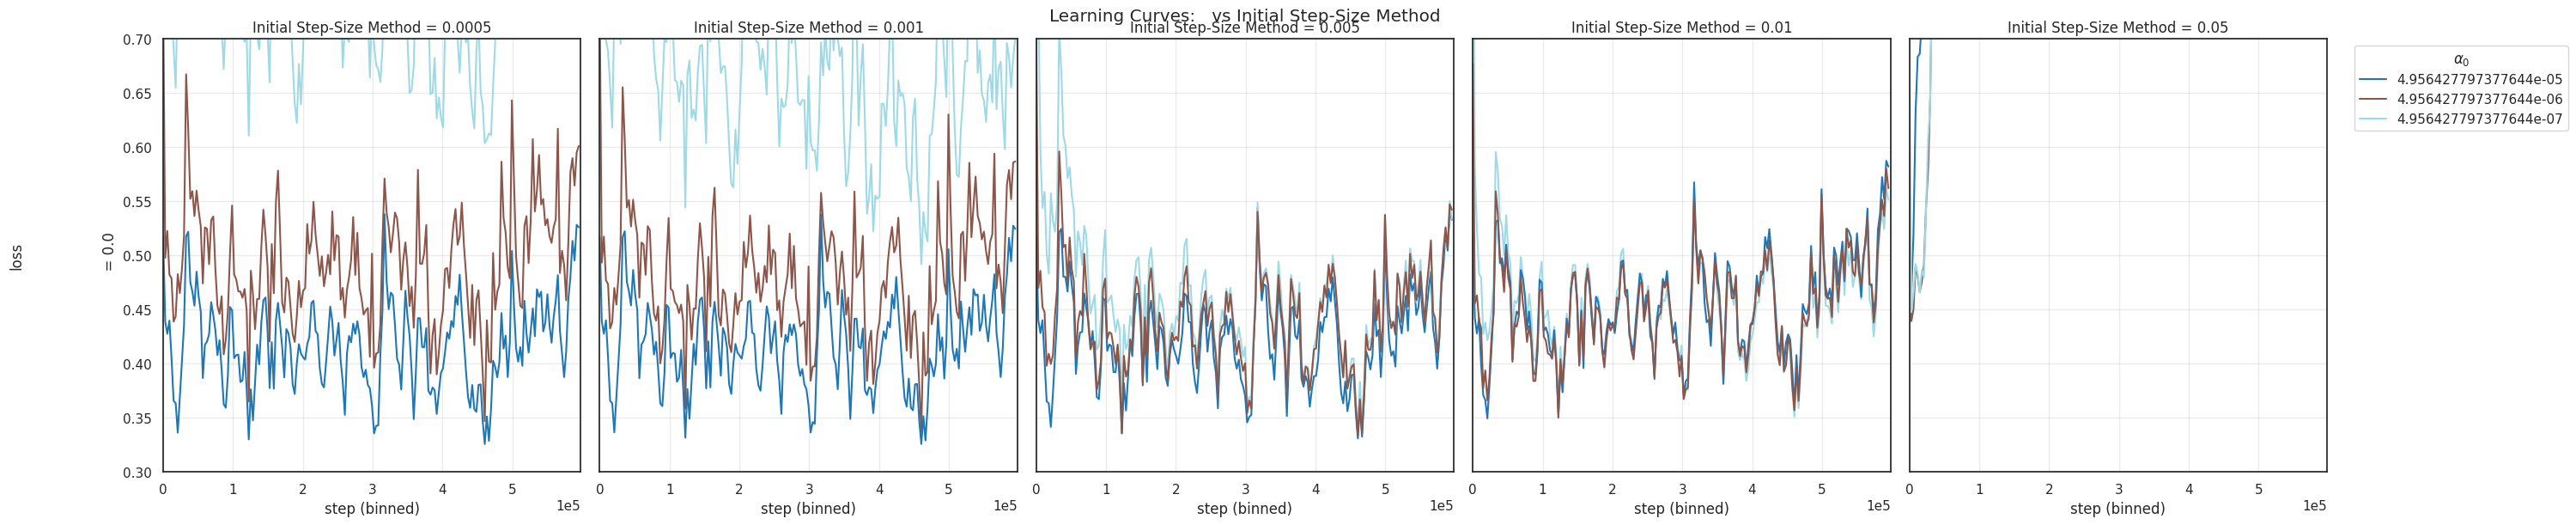

In [25]:
config_df = config_dfs['ns_meta_step_size'].copy()
config_df['optimizer|learning_rate'] = config_df['optimizer|learning_rate'].astype(str)
run_df = run_dfs['ns_meta_step_size'][run_dfs['ns_meta_step_size']['run_id'].isin(config_df['run_id'].unique())]

plot_learning_curves_grid(
    run_df = run_df,
    config_df = config_df,
    subplot_row_col = 'optimizer|step_size_decay',
    subplot_col_col = 'optimizer|meta_learning_rate',
    hue_col = 'optimizer|learning_rate',
    n_bins = 200,
    figsize = (30, 6),
    subplot_row_label = ' ',
    subplot_col_label = 'Initial Step-Size Method',
    hue_label = '$\\alpha_0$',
    same_y_axis = True,
    y_col = 'loss',
    y_label = None,
    x_lim = None,
    y_lim = (0.3, 0.7),
)